# Sentiment Analysis from Tweets

In [3]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
#nltk.download('wordnet')
#nltk.download('stopwords')
#from nltk.corpus import stopwords

## Input and Basic preprocessing

In [5]:
def parse_data_line(data):    # The input is a data line from the dataset, which has the ID, label and the tweet.
    return (data[1], data[2])    #  We will return only the label and the tweet. 
    
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

In [7]:
#stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def pre_process(text):   # Input: a string of one statement
    text = re.sub(r'@\w+', '', text)             # Remove mentions
    text = re.sub(r'http\S+', '', text)          # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)      # Remove punctuation
    text = text.lower()                          # Convert to lowercase
    tokens = text.split()
    #tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

The 're.findall' function finds the matches of the given pattern with the input text.

\r -> Raw text

\b -> Looks for word boundary - It matches the position between a word character (like letters, digits, or underscores) and a non-word character (like spaces or punctuation)

\w+ -> Any word which includes letters (upper or lowercase). + means one or more. 

## Basic Feature Extraction

In [8]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    feature_vector = {}  # This is the local dictionary we will return

    for token in tokens:
        if token in feature_vector:
            feature_vector[token] += 1   # Increment the count if the word/token is already in the dictionary
        else:
            feature_vector[token] = 1     # Add the token to the dictionary with count 1

        if token in global_feature_dict:   # This is an optional dictionary - used to track the count of words across the entire dataset.
            global_feature_dict[token] += 1
        else:
            global_feature_dict[token] = 1
    return feature_vector

In [9]:
# TRAINING AND VALIDATING OUR CLASSIFIER
def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(class_weight='balanced'))])
    return SklearnClassifier(pipeline).train(data)

## Cross-validation

In [10]:
def cross_validate(dataset, folds):
    fold_results = []  # List to store metrics for each fold
    results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': []
    }
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))
        validation_data = dataset[i:i+fold_size]
        training_data = dataset[:i] + dataset[i+fold_size:]

        X_train, y_train = zip(*training_data)
        X_test, y_test = zip(*validation_data)

        # Convert to lists and ensure they contain only strings
        X_train = [str(text) for text in X_train]
        X_test = [str(text) for text in X_test]

        vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.7)  # It uses unigrams and bigrams both
        X_train_tfidf = vectorizer.fit_transform(X_train)  # Fit on only X_train data
        X_test_tfidf = vectorizer.transform(X_test)

        X_train_tfidf, y_train = zip(*training_data)
        X_test_tfidf, y_test = zip(*validation_data)
        
        model = train_classifier(training_data)

        predictions = predict_labels(X_test_tfidf, model)

        p = precision_score(y_test, predictions, pos_label='positive', average='binary')
        r = recall_score(y_test, predictions, pos_label='positive', average='binary')
        f1 = f1_score(y_test, predictions, pos_label='positive', average='binary')
        a = accuracy_score(y_test, predictions)

        fold_results.append({
                'precision': p,
                'recall': r,
                'f1': f1,
                'accuracy': a
            })

        results['precision'].append(p)
        results['recall'].append(r)
        results['f1'].append(f1)
        results['accuracy'].append(a)

    avg_precision = sum(results['precision']) / folds
    avg_recall = sum(results['recall']) / folds
    avg_f1 = sum(results['f1']) / folds
    avg_accuracy = sum(results['accuracy']) / folds


    return {
        'fold_results': fold_results,
        'average': {
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': avg_f1,
            'accuracy': avg_accuracy
        }
    }

In [11]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(reviewSample)))

In [12]:
# MAIN

# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

# references to the data files
data_file_path = 'sentiment-dataset.tsv'

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
split_and_preprocess_data(0.8)

In [13]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...


{'fold_results': [{'precision': 0.8942255801403131,
   'recall': 0.8879957127545552,
   'f1': 0.8910997579994622,
   'accuracy': 0.8491058122205664},
  {'precision': 0.9098879688261081,
   'recall': 0.893352462936394,
   'f1': 0.9015444015444015,
   'accuracy': 0.8479880774962743},
  {'precision': 0.8575047498416719,
   'recall': 0.8261134838316047,
   'f1': 0.8415164698570541,
   'accuracy': 0.8099850968703428},
  {'precision': 0.8301886792452831,
   'recall': 0.844903988183161,
   'f1': 0.8374816983894583,
   'accuracy': 0.834575260804769},
  {'precision': 0.8768699654775605,
   'recall': 0.8644356211003971,
   'f1': 0.8706083976006855,
   'accuracy': 0.8312220566318927},
  {'precision': 0.8791455874086566,
   'recall': 0.8921848260125499,
   'f1': 0.8856172140430351,
   'accuracy': 0.849478390461997},
  {'precision': 0.8843995510662177,
   'recall': 0.8824188129899216,
   'f1': 0.8834080717488789,
   'accuracy': 0.8450074515648286},
  {'precision': 0.88558352402746,
   'recall': 0.8

## Error Analysis

In [14]:
# A function to make the confusion matrix readable
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

Training Classifier...


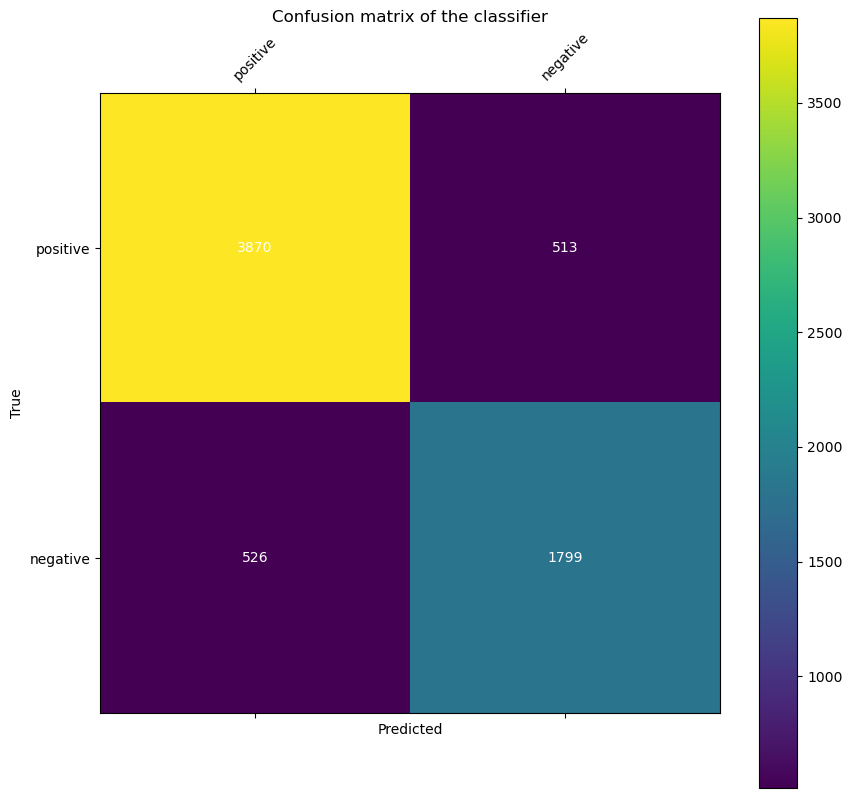

In [15]:
X_test, y_test = zip(*test_data)
classifier = train_classifier(train_data)
predictions = predict_labels(X_test, classifier)

confusion_matrix_heatmap(y_test, predictions, ['positive', 'negative'])

In [16]:
confusion_matrix(y_test, predictions, normalize='true')

array([[0.77376344, 0.22623656],
       [0.11704312, 0.88295688]])

In [17]:
false_positives = []
false_negatives = []

for i, (actual, predicted) in enumerate(zip(y_test, predictions)):
    if actual == 'negative' and predicted == 'positive':
        false_positives.append(i)  # Index or data point of the false positive
    elif actual == 'positive' and predicted == 'negative':
        false_negatives.append(i)  # Index or data point of the false negative

In [18]:
# for i in false_positives[:20]:
#     print(X_test[i])

In [19]:
# for i in false_negatives[:20]:
#     print(X_test[i])

## Testing on unseen Test Data

In [20]:
# Finally, check the accuracy of the classifier by training on all the traning data and testing on the test set
functions_complete = True
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, 'well': 2, 'release': 1, 'our': 2, 'th': 1, 'episode': 1, 'of': 1, 'hsonair': 1, 'profiling': 1, 'very': 1, 'own': 1, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'beyonce': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.844912
Recall: 0.845110
F Score:0.845008
